<h1 style="text-align:center;"><u>Brain Tumor Detection🕵️‍♂️</u></h1>

<hr>


## 1. Abstract :
Brain tumors vary in their position, mass, nature, and consistency of these lesions. Due to the similarities found between brain lesions and normal tissues, many challenges are faced by the researcher in developing algorithms for tumor segmentation. Brain tumor abstraction is thought-provoking job in medical image handing out because brain image and its structure is complicated.

Optical imaging and artificial intelligence are making brain tumor diagnosis quicker and more accurate. My Project aim for providing the baseline TUMOR detection model. Vist <a href="https://youtu.be/UZZ08_fC7UU">here</a> for more motivation.


<img src="https://www.larazon.es/resizer/Iv78XQbZONjqB5ef5PF-2O6BbZ8=/1260x840/smart/filters:format(webp)/cloudfront-eu-central-1.images.arcpublishing.com/larazon/XCKGU7PEINFD3DKCRX6KU4ABBA.jpg" width="600">

<br>

## 2. Project(*part-ii*) Overview :
Rather than classifying **Brain MRI scans** ! I'm now more concern about building  an actual **DETECTOR**(DL Model)  which will point out on the location of the tumor on the scan along it's **MASK** using **Mask R-CNN**.

![](https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcR88WgtTXGhH0gsjHYQNI7GREyGvVIiY9I35Q&usqp=CAU)


### Table of Contents
* <p style="color: blue">Image Data Analysis and Classification </p>
* <p style="color: blue">Setting up development environment</p>
* <p style="color: blue">Setting up Model Configuration and Data Generators</p>
* <p style="color: blue">Model traning</p>
* <p style="color: blue">Tesing model performance</p>
* <p style="color: blue">Evaluation</p>



<hr>

## Image Data Analysis and Classification

### This part is now under Project(*part-i*).

<img src="https://tajwarabraraleef.github.io/img/headers/brain.PNG" width="600">

# Setting up development environment

In [ ]:
!pip install tensorflow==1.15.0
!pip install keras==2.0.8

In [1]:
!git clone https://github.com/matterport/Mask_RCNN.git # load Mask R-CNN code implementation
!pip install pycocotools

%cd ./Mask_RCNN

Cloning into 'Mask_RCNN'...
remote: Enumerating objects: 956, done.
remote: Total 956 (delta 0), reused 0 (delta 0), pack-reused 956
Receiving objects: 100% (956/956), 111.85 MiB | 44.42 MiB/s, done.
Resolving deltas: 100% (563/563), done.
Cloning into 'brain-tumor'...
remote: Enumerating objects: 263, done.
remote: Counting objects: 100% (263/263), done.
remote: Compressing objects: 100% (256/256), done.
remote: Total 263 (delta 6), reused 263 (delta 6), pack-reused 0
Receiving objects: 100% (263/263), 6.79 MiB | 0 bytes/s, done.
Resolving deltas: 100% (6/6), done.
  Created wheel for pycocotools: filename=pycocotools-2.0.2-cp36-cp36m-linux_x86_64.whl size=286658 sha256=ceba9a4bc76817841b5aee048ac5b294506fa35db3b25c1084c184b37fe8fba4
  Stored in directory: /root/.cache/pip/wheels/68/a5/e7/56401832f23d0b2db351c5b682e466cb4841960b086da65e4e
Successfully built pycocotools
/kaggle/working/Mask_RCNN


In [2]:
import os 
import sys
from tqdm import tqdm
import cv2
import numpy as np
import json
import skimage.draw
import matplotlib
import matplotlib.pyplot as plt
import random

In [3]:
# Root directory of the project
###ROOT_DIR = os.path.abspath('')

ROOT_DIR = os.path.abspath('')
# Import Mask RCNN
sys.path.append(ROOT_DIR) 
from mrcnn.config import Config
from mrcnn import utils
from mrcnn.model import log
import mrcnn.model as modellib
from mrcnn import visualize
# Import COCO config
sys.path.append(os.path.join(ROOT_DIR, 'samples/coco/'))
import coco


/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

## Setting up Model Configuration and Data Generators

In [4]:
MODEL_DIR = os.path.join(ROOT_DIR, 'logs') # directory to save logs and trained model
# ANNOTATIONS_DIR = 'brain-tumor/data/new/annotations/' # directory with annotations for train/val sets
DATASET_DIR = '../brain-tumor/data_cleaned/' # directory with image data
DEFAULT_LOGS_DIR = 'logs' 

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

... done downloading pretrained model!


In [5]:
def get_ax(rows=1, cols=1, size=7):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

In [6]:
class Model_Config(Config):
    """Configuration for training on the brain tumor dataset.
    """
    # Give the configuration a recognizable name
    NAME = 'Tumor_detector'
    # Train on 1 GPU and 3 images per GPU. We can put multiple images on each
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # background + tumor
    IMAGE_MIN_DIM = 256
    IMAGE_MAX_DIM= 256
    
    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels
    
    DETECTION_MIN_CONFIDENCE = 0.70
    VALIDATION_STEPS = 6
    STEPS_PER_EPOCH = 100
    LEARNING_RATE = 0.001
    
config = Model_Config()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  256
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  256
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [256 256   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE             

In [7]:
class Brain_Tumor_Dataset(utils.Dataset):

    def load_brain_scan(self, dataset_dir, subset):
        """Load a subset of the FarmCow dataset.
        dataset_dir: Root directory of the dataset.
        subset: Subset to load: train or val
        """
        # Add classes. We have only one class to add.
        self.add_class("tumor", 1, "tumor")

        # Train or validation dataset?
        assert subset in ["train", "val", 'test']
        dataset_dir = os.path.join(dataset_dir, subset)

        annotations = json.load(open(os.path.join(DATASET_DIR, subset, 'annotations_'+subset+'.json')))
        annotations = list(annotations.values())  # don't need the dict keys

        # The VIA tool saves images in the JSON even if they don't have any
        # annotations. Skip unannotated images.
        annotations = [a for a in annotations if a['regions']]

        # Add images
        for a in annotations:
            # Get the x, y coordinaets of points of the polygons that make up
            # the outline of each object instance. These are stores in the
            # shape_attributes (see json format above)
            # The if condition is needed to support VIA versions 1.x and 2.x.
            if type(a['regions']) is dict:
                polygons = [r['shape_attributes'] for r in a['regions'].values()]
            else:
                polygons = [r['shape_attributes'] for r in a['regions']]

            # load_mask() needs the image size to convert polygons to masks.
            # Unfortunately, VIA doesn't include it in JSON, so we must read
            # the image. This is only managable since the dataset is tiny.
            image_path = os.path.join(dataset_dir, a['filename'])
            image = skimage.io.imread(image_path)
            height, width = image.shape[:2]

            self.add_image(
                "tumor",
                image_id=a['filename'],  # use file name as a unique image id
                path=image_path,
                width=width, 
                height=height,
                polygons=polygons
            )

    def load_mask(self, image_id):
        """Generate instance masks for an image.
       Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        # If not a farm_cow dataset image, delegate to parent class.
        image_info = self.image_info[image_id]
        if image_info["source"] != "tumor":
            return super(self.__class__, self).load_mask(image_id)

        # Convert polygons to a bitmap mask of shape
        # [height, width, instance_count]
        info = self.image_info[image_id]
        mask = np.zeros([info["height"], info["width"], len(info["polygons"])],
                        dtype=np.uint8)
        for i, p in enumerate(info["polygons"]):
            # Get indexes of pixels inside the polygon and set them to 1
            rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])
            mask[rr, cc, i] = 1

        # Return mask, and array of class IDs of each instance. Since we have
        # one class ID only, we return an array of 1s
        return mask.astype(np.bool), np.ones([mask.shape[-1]], dtype=np.int32)

    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "tumor":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)

In [8]:
# Training dataset.
dataset_train = Brain_Tumor_Dataset()
dataset_train.load_brain_scan(DATASET_DIR, 'train')
dataset_train.prepare()

# Validation dataset
dataset_val = Brain_Tumor_Dataset()
dataset_val.load_brain_scan(DATASET_DIR, 'val')
dataset_val.prepare()

# Test dataset
dataset_test = Brain_Tumor_Dataset()
dataset_test.load_brain_scan(DATASET_DIR, 'test')
dataset_test.prepare()

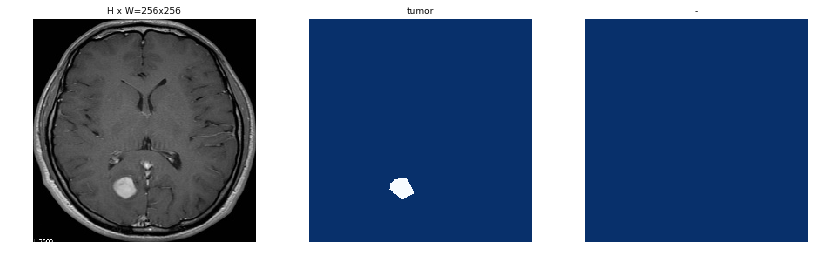

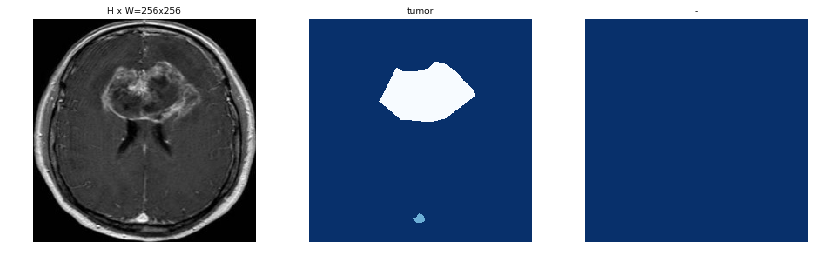

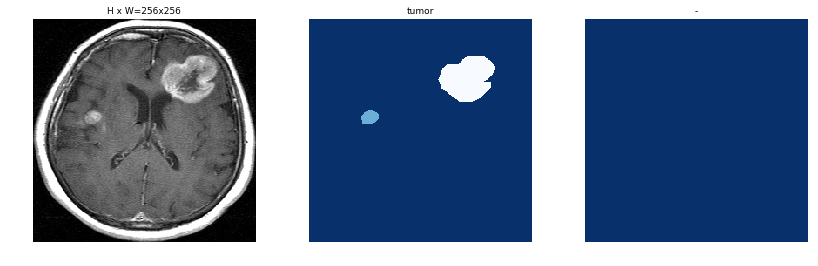

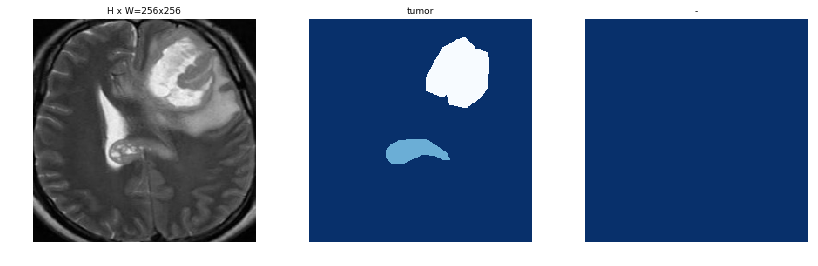

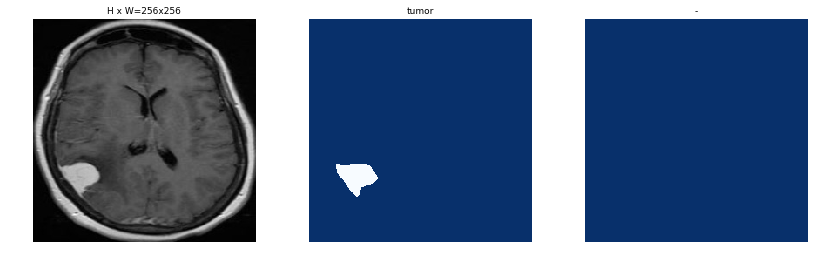

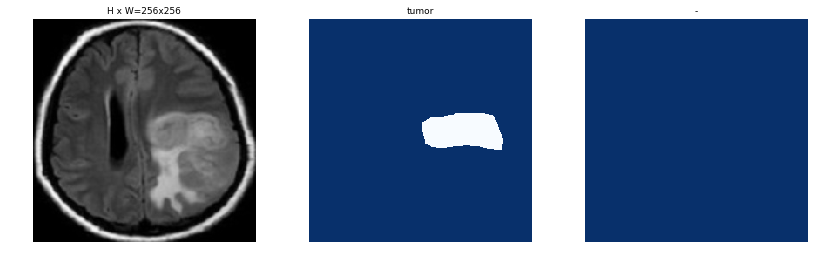

In [70]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 6)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names, limit=2)


## Model traning


In [10]:
model = modellib.MaskRCNN(
    mode='training', 
    config=config, 
    model_dir= DEFAULT_LOGS_DIR)


In [11]:
model.load_weights(
    COCO_MODEL_PATH, 
    by_name=True, 
    exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", "mrcnn_bbox", "mrcnn_mask"]
)

In [14]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
print("Training network heads")

model.train(
    dataset_train, dataset_val,
    learning_rate=config.LEARNING_RATE,
    epochs=18,
    layers='heads'
)

Training network heads

Starting at epoch 0. LR=0.001

Checkpoint Path: logs/tumor_detector20200913T0453/mask_rcnn_tumor_detector_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistri

/opt/conda/lib/python3.6/site-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/opt/conda/lib/python3.6/site-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/opt/conda/lib/python3.6/site-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/opt/conda/lib/python3.6/site-packages/keras/engine/training_generator.py:47: UserWarning: Using a generator with `use_multiprocessing=True` and multiple worker

Epoch 1/18
100/100 [==============================] - 40s 404ms/step - loss: 2.6785 - rpn_class_loss: 0.0307 - rpn_bbox_loss: 1.4695 - mrcnn_class_loss: 0.0424 - mrcnn_bbox_loss: 0.6946 - mrcnn_mask_loss: 0.4413 - val_loss: 1.3924 - val_rpn_class_loss: 0.0197 - val_rpn_bbox_loss: 0.7759 - val_mrcnn_class_loss: 0.0171 - val_mrcnn_bbox_loss: 0.4005 - val_mrcnn_mask_loss: 0.1791
Epoch 2/18
100/100 [==============================] - 24s 235ms/step - loss: 1.5399 - rpn_class_loss: 0.0265 - rpn_bbox_loss: 0.7891 - mrcnn_class_loss: 0.0153 - mrcnn_bbox_loss: 0.4612 - mrcnn_mask_loss: 0.2478 - val_loss: 1.6261 - val_rpn_class_loss: 0.0308 - val_rpn_bbox_loss: 0.7346 - val_mrcnn_class_loss: 0.0221 - val_mrcnn_bbox_loss: 0.5830 - val_mrcnn_mask_loss: 0.2555
Epoch 3/18
100/100 [==============================] - 24s 241ms/step - loss: 1.5078 - rpn_class_loss: 0.0223 - rpn_bbox_loss: 0.6487 - mrcnn_class_loss: 0.0148 - mrcnn_bbox_loss: 0.5765 - mrcnn_mask_loss: 0.2455 - val_loss: 1.4994 - val_rpn_c

## Tesing model performance

### 1. Recreating the model in inference mode

In [19]:
# Recreate the model in inference mode
model = modellib.MaskRCNN(
    mode="inference", 
    config=config,
    model_dir=DEFAULT_LOGS_DIR
)


In [46]:
# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()
model_path

'logs/tumor_detector20200913T0453/mask_rcnn_tumor_detector_0018.h5'

In [23]:
# Load trained weights -- 'logs/tumor_detector20200913T0453/mask_rcnn_tumor_detector_0018.h5'
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  logs/tumor_detector20200913T0453/mask_rcnn_tumor_detector_0018.h5
Re-starting from epoch 18


![](http://)<a href="./Mask_RCNN/logs/tumor_detector20200913T0453/mask_rcnn_tumor_detector_0018.h5">download_model</a>

In [63]:
def predict_and_plot_diff(dataset, img_id, verbose=0):
    original_image, image_meta, gt_class_id, gt_box, gt_mask =\
        modellib.load_image_gt(dataset, config, 
                               img_id, use_mini_mask=False)

    results = model.detect([original_image], verbose= verbose)
    r = results[0]

    visualize.display_differences(
        original_image,
        gt_box, gt_class_id, gt_mask,
        r['rois'], r['class_ids'], r['scores'], r['masks'],
        class_names = ['tumor'], title="", ax=get_ax(),
        show_mask=True, show_box=True, iou_threshold=0.5, score_threshold=0.6)
    
    
def display_image(dataset, ind):
    plt.figure(figsize=(6,5))
    plt.imshow(dataset.load_image(ind))
    plt.xticks([]); plt.yticks([])
    plt.title('Original Image')
    plt.show()

### 2. Performance on Validation data

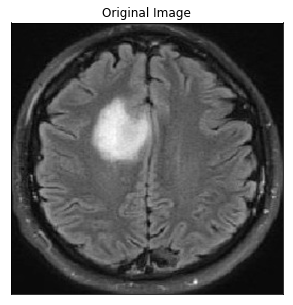

Processing 1 images
image                    shape: (256, 256, 3)         min:    4.00000  max:  253.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -119.70000  max:  149.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.35494  max:    1.10396  float32


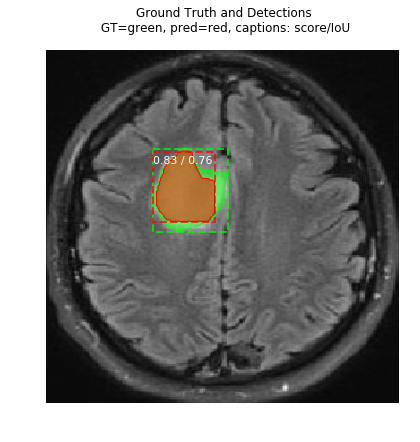

In [64]:
ind = 0
display_image(dataset_val, ind)
predict_and_plot_diff(dataset_val, ind, verbose=1)

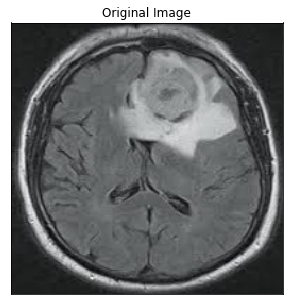

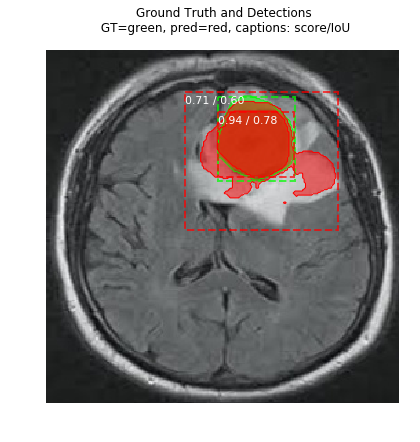

In [30]:
ind = 10
display_image(dataset_val, ind)
predict_and_plot_diff(dataset_val, ind)

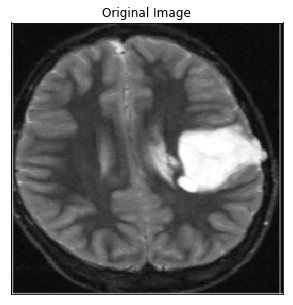

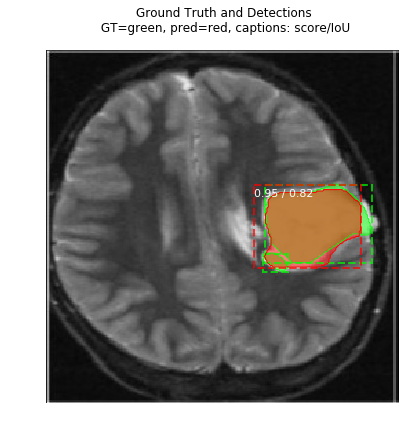

In [34]:
ind = 8
display_image(dataset_val, ind)
predict_and_plot_diff(dataset_val, ind)

### 2. Performance on Test data

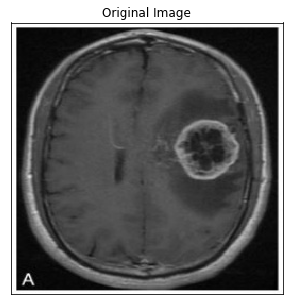

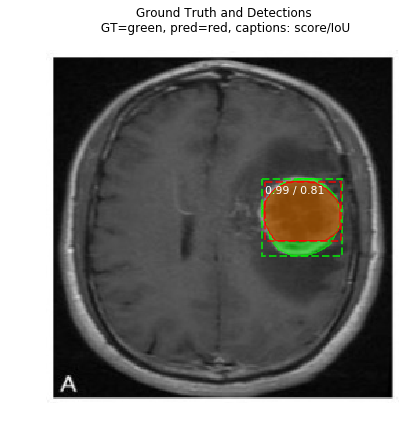

In [36]:
ind = 0
display_image(dataset_test, ind)
predict_and_plot_diff(dataset_test, ind)

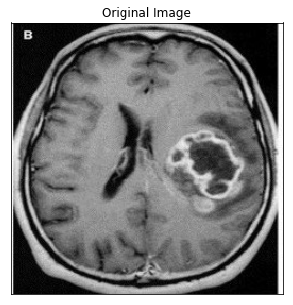

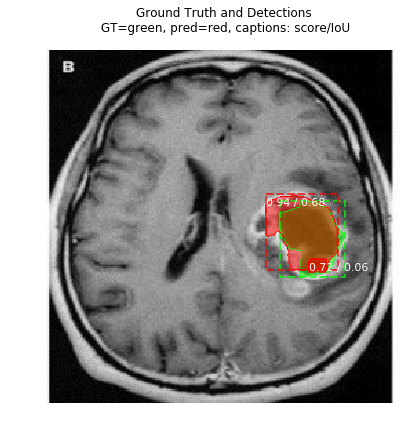

In [60]:
ind = 1
display_image(dataset_test, ind)
predict_and_plot_diff(dataset_test, ind)

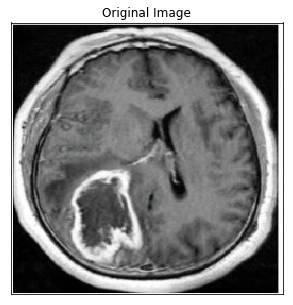

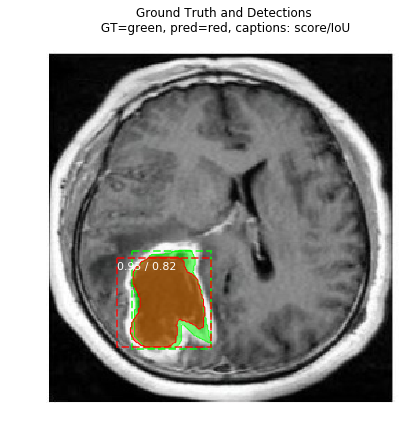

In [40]:
ind = 2
display_image(dataset_test, ind)
predict_and_plot_diff(dataset_test, ind)

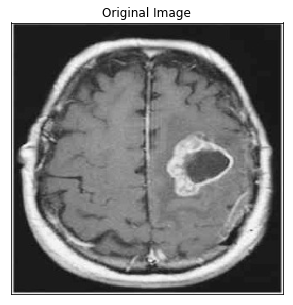

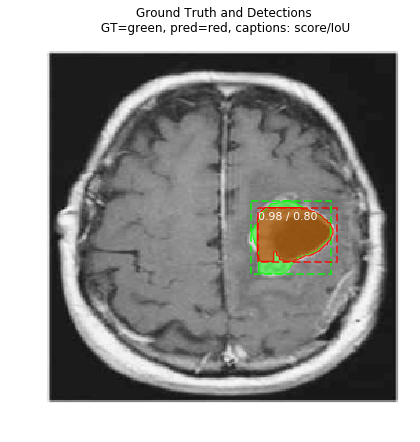

In [37]:
ind = 3
display_image(dataset_test, ind)
predict_and_plot_diff(dataset_test, ind)

# Evaluation
1. Validation images
2. Test images

In [59]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
image_ids = dataset_val.image_ids
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, config,
                               image_id, use_mini_mask=False)
    #molded_images = np.expand_dims(modellib.mold_image(image, config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))

mAP:  0.7604761912212485


In [67]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
image_ids = dataset_test.image_ids
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_test, config,
                               image_id, use_mini_mask=False)
    #molded_images = np.expand_dims(modellib.mold_image(image, config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))

mAP:  1.0
